Visualizing Wavelet Noise Band-Limited Property...


AttributeError: 'numpy.ndarray' object has no attribute 'axis'

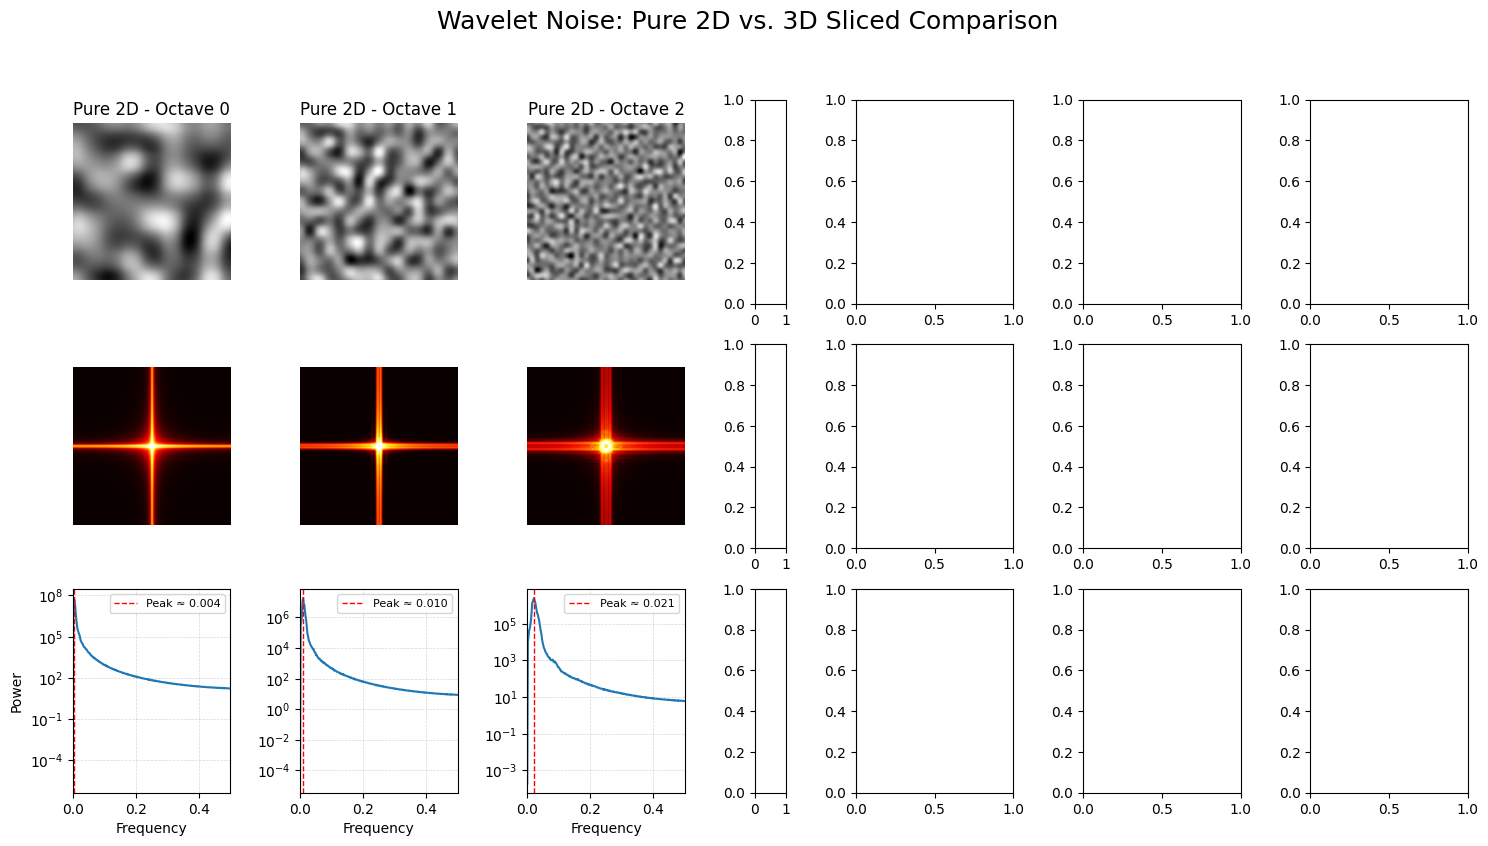

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from mpl_toolkits.mplot3d import Axes3D
import os

def load_raw_data(filename, size=512):
    """Loads a raw float32 file into a numpy array."""
    try:
        with open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.float32)
        expected_size = size * size
        if data.size != expected_size:
            print(f"Warning: Size mismatch in {filename}. Expected {expected_size}, got {data.size}.")
            return None
        return data.reshape((size, size))
    except FileNotFoundError:
        print(f"Warning: File not found - {filename}")
        return None
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        return None

def plot_noise_column(ax_col, data, title):
    """Plots a full analysis column (pattern, fft, radial) for given data."""
    if data is None:
        # Handle case where data failed to load
        for ax in ax_col:
            ax.text(0.5, 0.5, 'Data not found', ha='center', va='center')
            ax.axis('off')
        ax_col[0].set_title(title, fontsize=12)
        return

    # --- Calculations ---
    data_centered = data - np.mean(data)
    F = fftshift(fft2(data_centered))
    power_spectrum = np.abs(F) ** 2

    h, w = power_spectrum.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    R = np.sqrt((X - cx)**2 + (Y - cy)**2)
    
    max_r = min(cx, cy)
    radial_profile = []
    for r in range(max_r):
        mask = (R >= r) & (R < r + 1)
        if np.any(mask):
            radial_profile.append(np.mean(power_spectrum[mask]))
        else:
             radial_profile.append(0)

    freqs = np.arange(len(radial_profile)) / (2 * len(radial_profile))
    
    # --- Plotting ---
    # 1. Noise Pattern
    ax = ax_col[0]
    ax.imshow(data, cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

    # 2. Power Spectrum (log scale)
    ax = ax_col[1]
    power_log = np.log1p(power_spectrum)
    # Use percentile to avoid extreme values from dominating the color scale
    vmax = np.percentile(power_log, 99.8)
    ax.imshow(power_log, cmap='hot', vmin=0, vmax=vmax)
    ax.axis('off')

    # 3. Radial Profile
    ax = ax_col[2]
    ax.semilogy(freqs, radial_profile, linewidth=1.5)
    ax.set_xlim(0, 0.5)
    ax.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xlabel('Frequency')
    peak_freq = freqs[np.argmax(radial_profile)]
    ax.axvline(peak_freq, color='r', linestyle='--', linewidth=1, label=f'Peak ≈ {peak_freq:.3f}')
    ax.legend(fontsize=8)
    
    # Set y-label only for the first column
    if ax.get_subplotspec().colspan.start == 0:
        ax.set_ylabel('Power')


def create_comparison_figure():
    """Generates the main comparison figure for 2D vs 3D sliced noise."""
    
    octaves = [0, 1, 2]
    
    # --- 修正點在這裡 ---
    # 我們總共有 3 (2D) + 1 (間隔) + 3 (3D) = 7 欄
    num_cols = len(octaves) + 1 + len(octaves)
    num_rows = 3
    
    # 創建一個 3 行, 7 欄的網格
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 9),
                             gridspec_kw={'width_ratios': [1, 1, 1, 0.2, 1, 1, 1], 'wspace': 0.5})
    
    plt.suptitle('Wavelet Noise: Pure 2D vs. 3D Sliced Comparison', fontsize=18, y=0.98)

    # --- Pure 2D Noise (Top Row of Conceptual Blocks) ---
    for i, oct in enumerate(octaves):
        filename = f"wavelet_noise_2D_octave_{oct}.raw"
        data = load_raw_data(filename)
        title = f"Pure 2D - Octave {oct}"
        # plot_noise_column 需要傳入對應的欄位軸 (axes column)
        plot_noise_column(axes[:, i], data, title)

    # --- 3D Sliced Noise (Bottom Row of Conceptual Blocks) ---
    # 將中間的第 4 欄 (索引為 3) 設為不可見，作為間隔
    axes[:, 3].axis('off') 

    for i, oct in enumerate(octaves):
        # 3D 噪聲的圖放在第 5, 6, 7 欄 (索引為 4, 5, 6)
        col_idx = i + 4
        # 我們為 3D 生成的是 octave 3, 4, 5
        filename = f"wavelet_noise_3Dsliced_octave_{oct + 3}.raw"
        data = load_raw_data(filename)
        title = f"3D Sliced - Octave {oct + 3}"
        plot_noise_column(axes[:, col_idx], data, title)
        
    fig.text(0.26, 0.93, 'Pure 2D Wavelet Noise', ha='center', va='center', fontsize=14, weight='bold')
    fig.text(0.74, 0.93, '3D Sliced Wavelet Noise', ha='center', va='center', fontsize=14, weight='bold')

    # 調整佈局以避免重疊
    plt.tight_layout(rect=[0, 0, 1, 0.90])
    # 由於 tight_layout 可能會覆蓋 wspace，我們再手動調整一次
    plt.subplots_adjust(wspace=0.5)

    plt.savefig("wavelet_2D_vs_3D_comparison.png", dpi=150)
    plt.show()


if __name__ == "__main__":
    print("Visualizing Wavelet Noise Band-Limited Property...")
    print("=" * 60)
    
    create_comparison_figure()
    
    print("\nAnalysis complete!")
    print("The comparison figure 'wavelet_2D_vs_3D_comparison.png' has been generated.")
    print("Observe the clear band separation (dark center) in the Pure 2D power spectra,")
    print("versus the low-frequency leakage in the 3D Sliced power spectra.")

Visualizing Wavelet Noise Band-Limited Property...


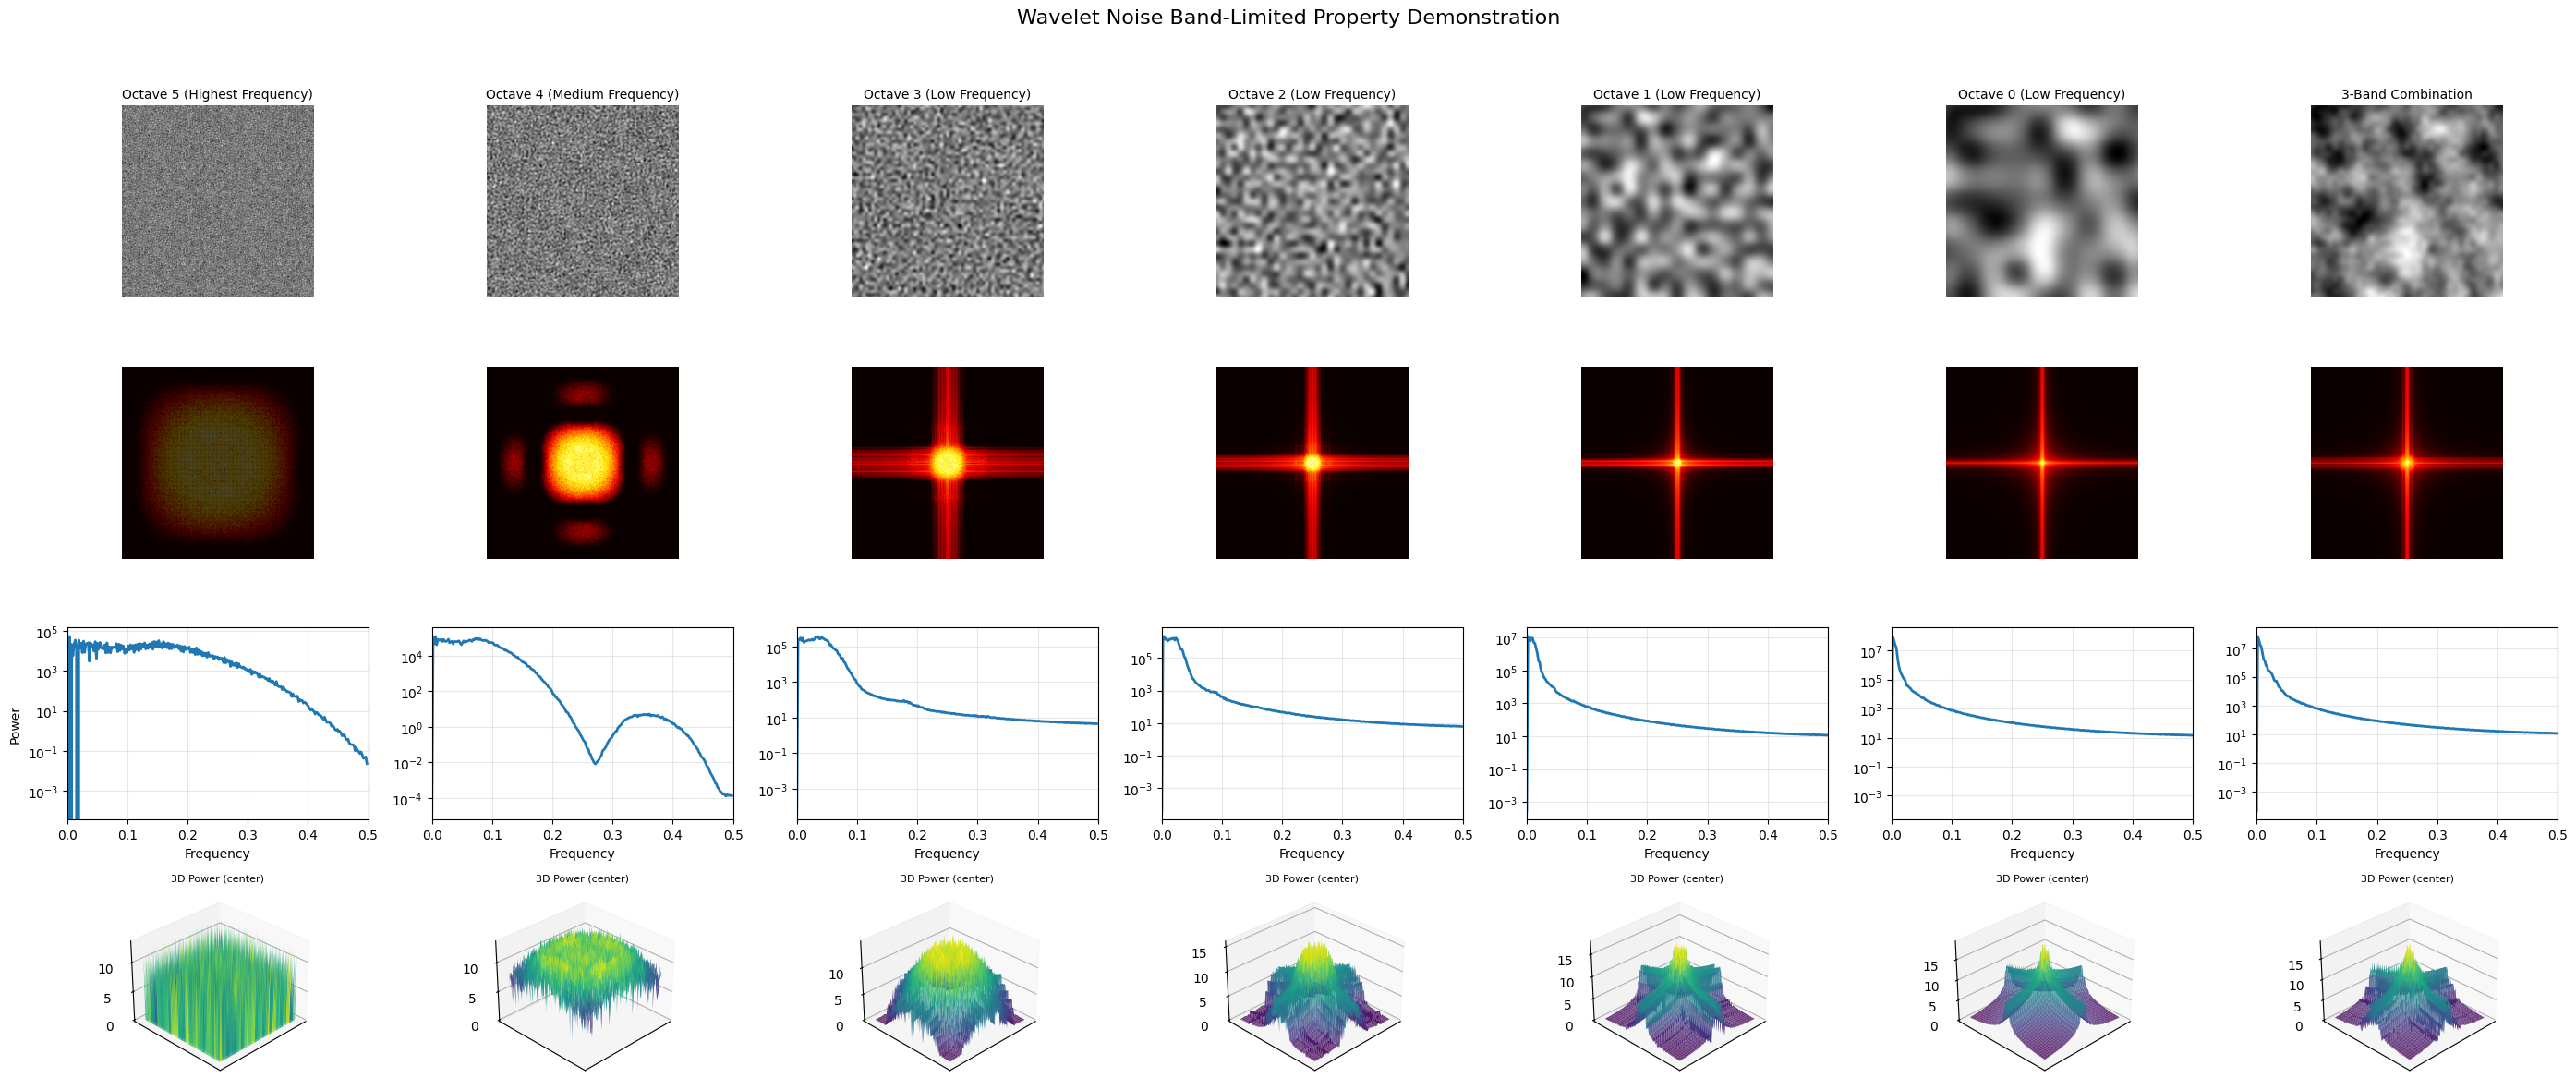

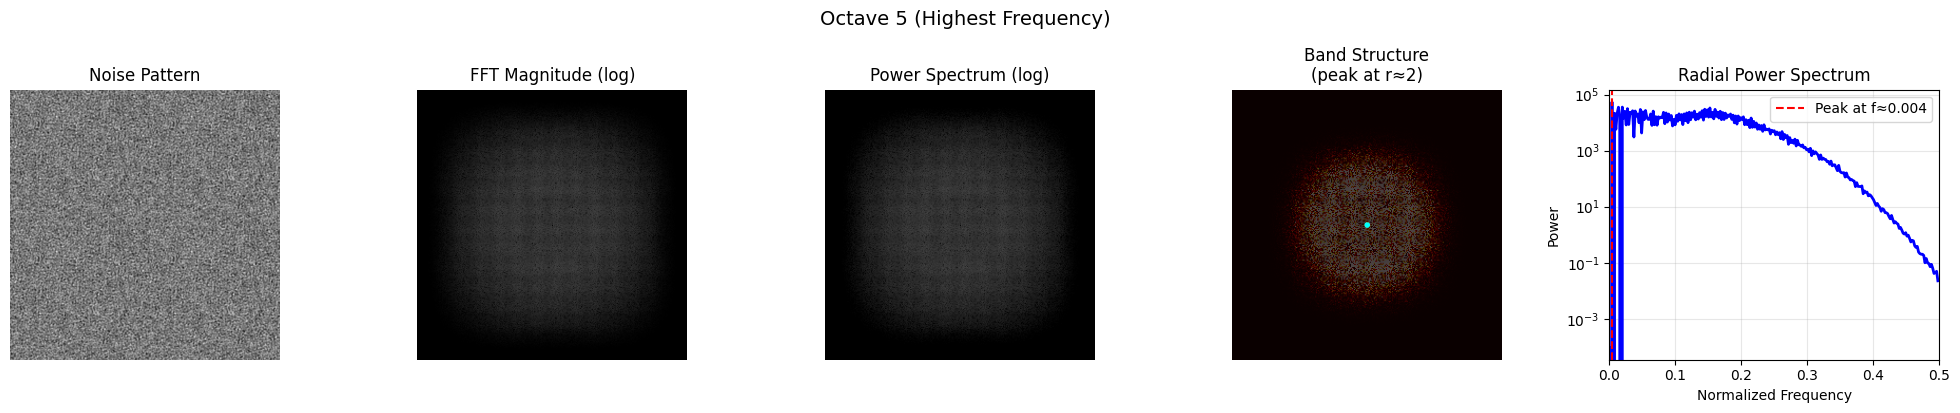

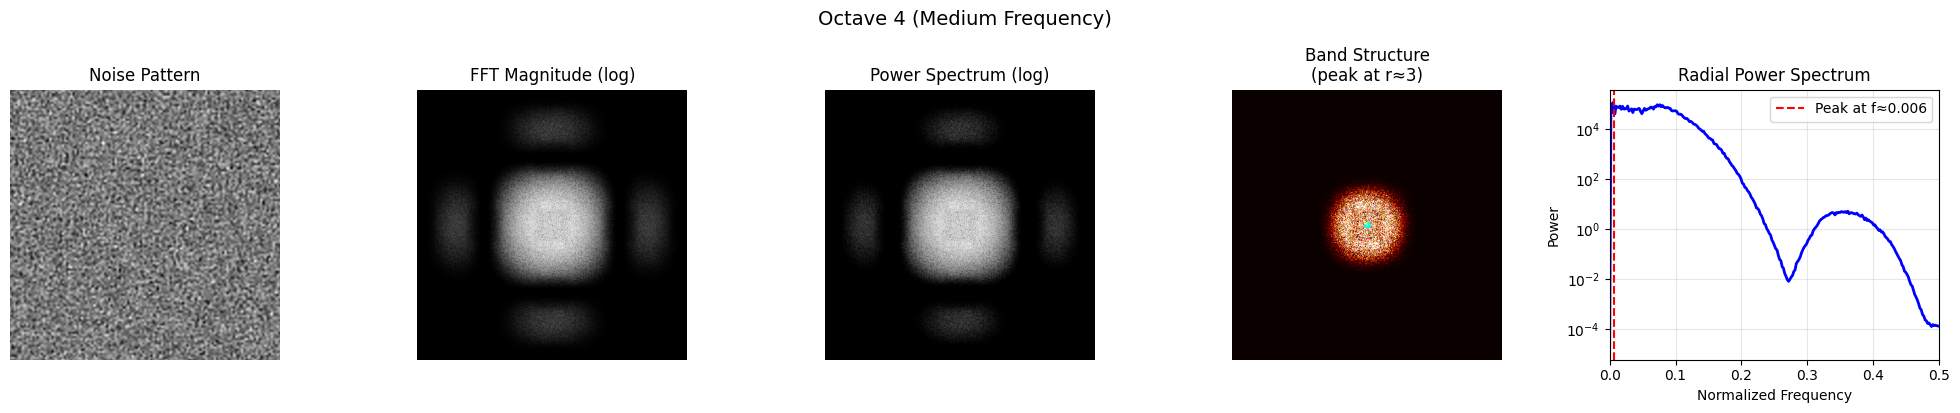

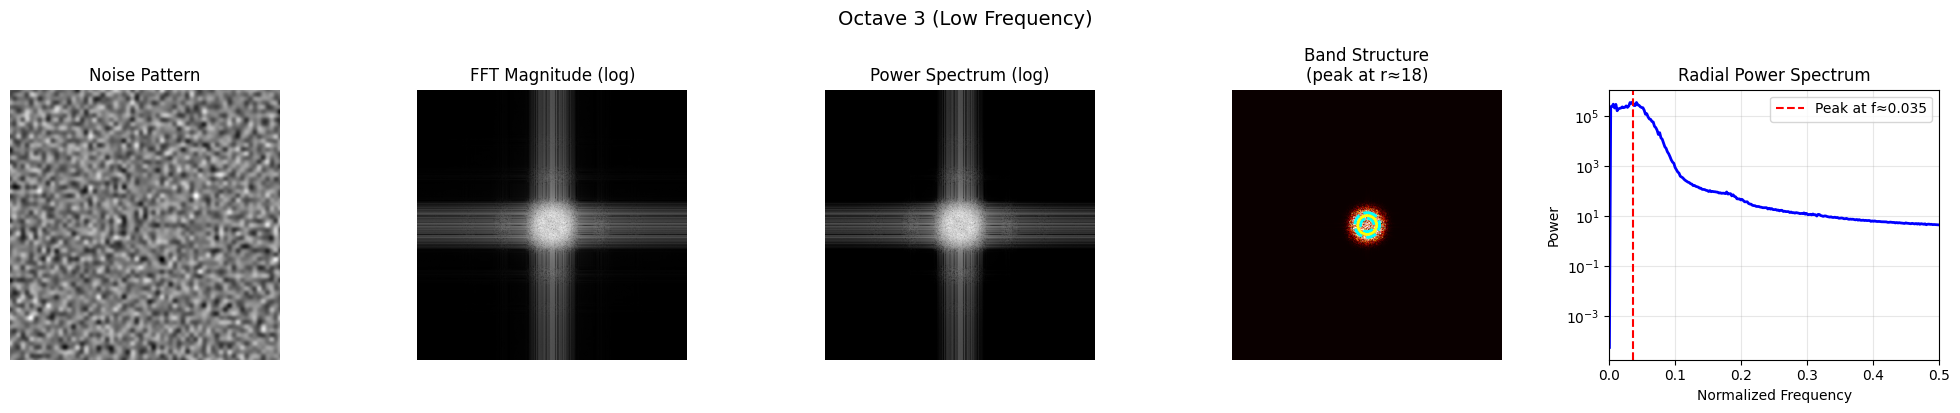

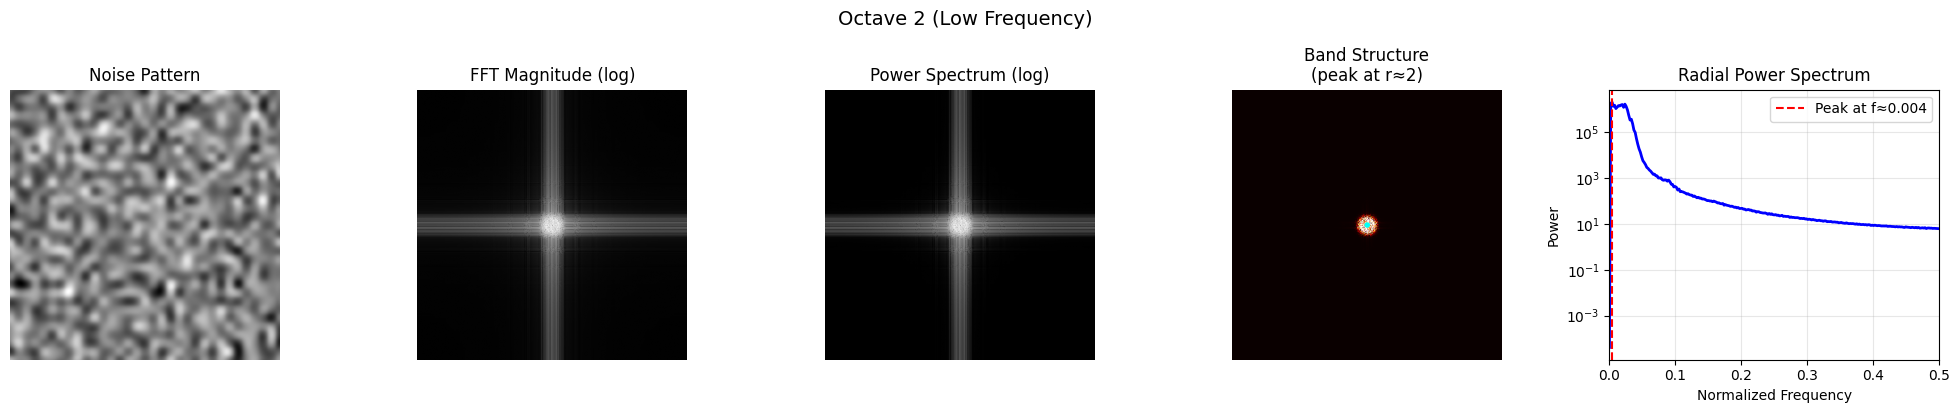

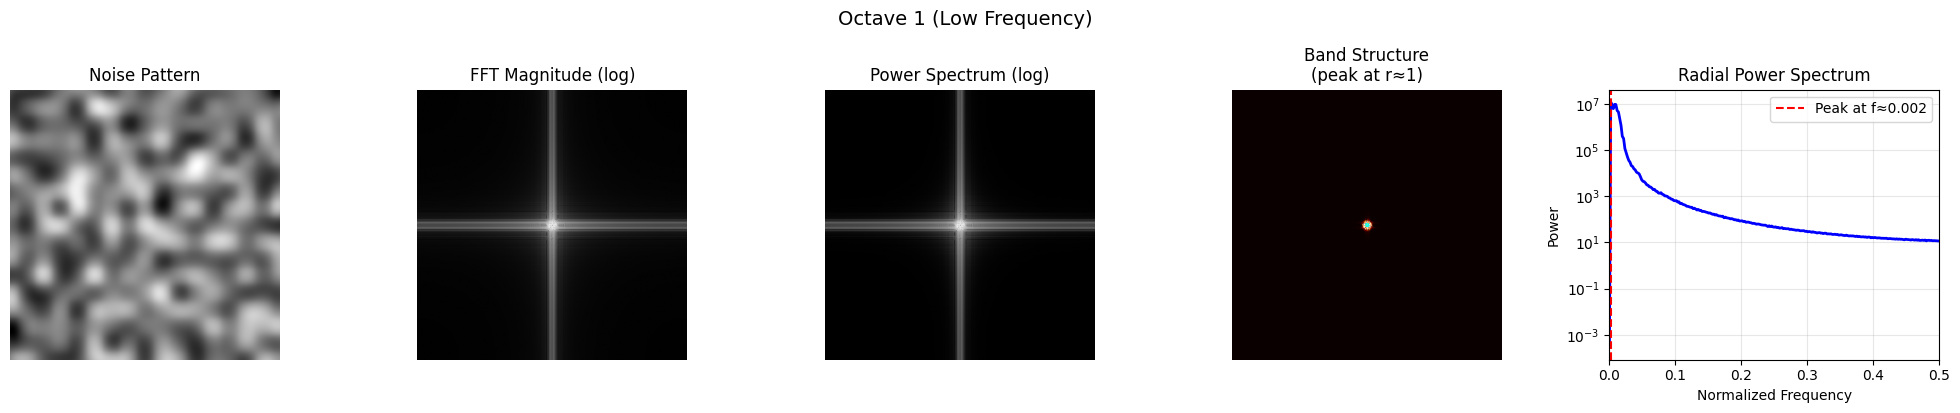

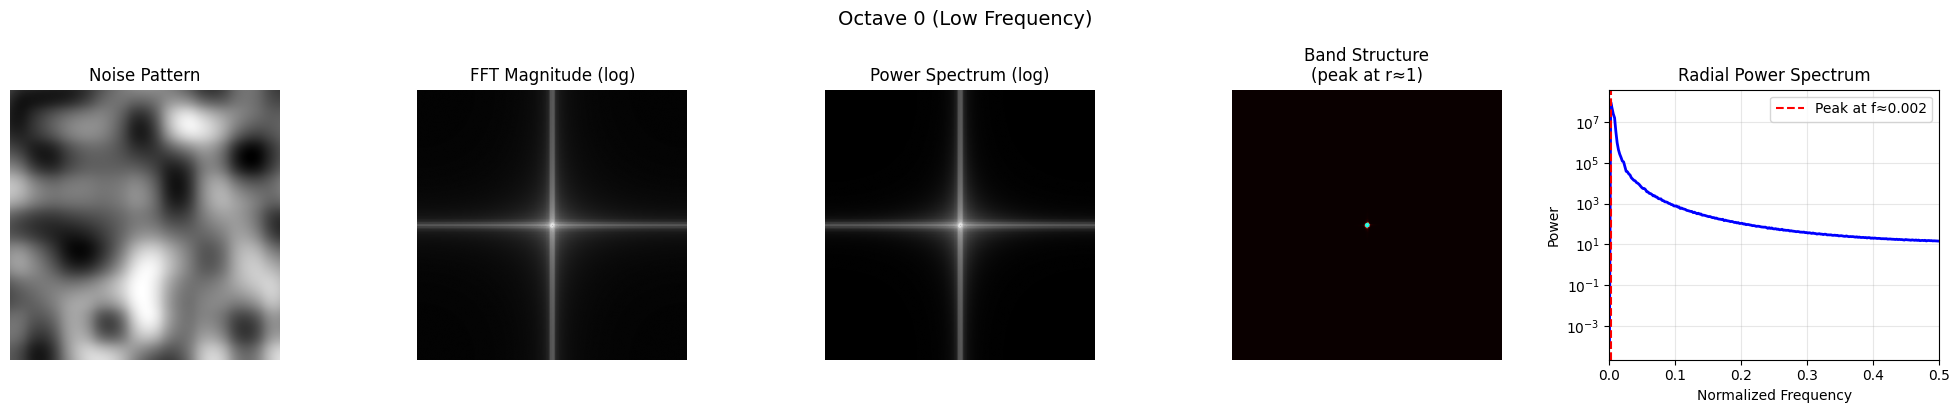

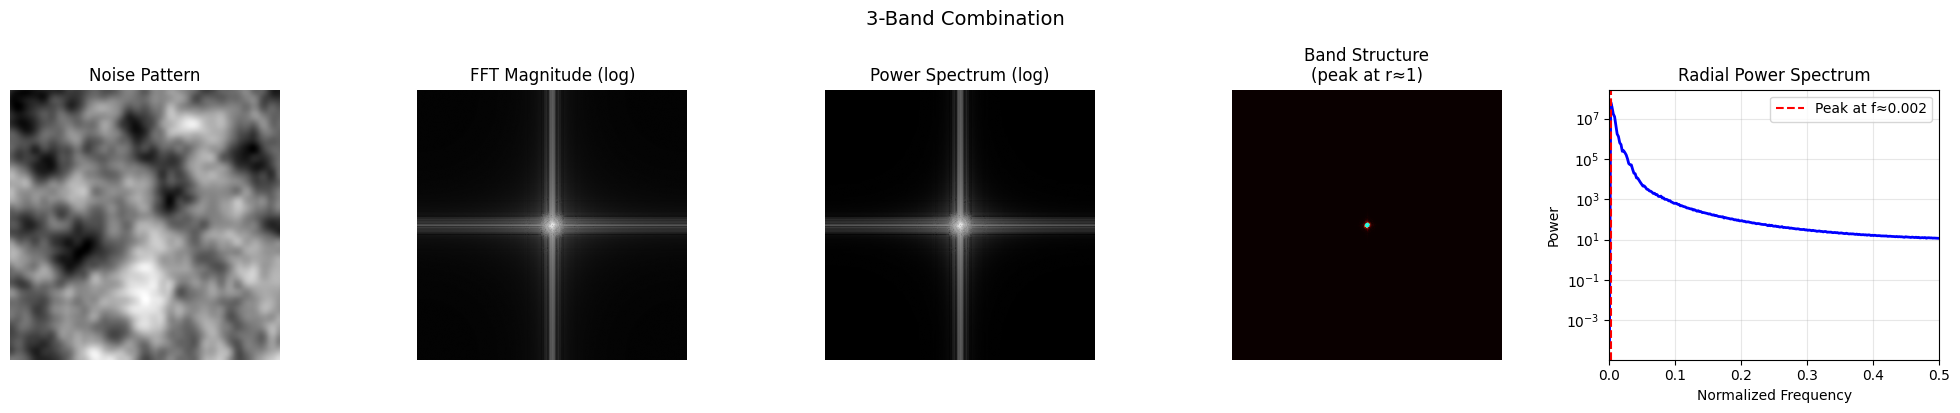


The band-limited property is demonstrated by:
1. Each band has energy concentrated in a ring/annulus in frequency domain
2. Different bands have peaks at different frequencies (octaves apart)
3. Very little energy outside the designed frequency band
4. The 3-band combination shows multiple rings

Analysis complete!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plots
import os

def analyze_single_band(filename, title):
    """Analyze a single band noise pattern to show band-limited property"""
    try:
        with open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.float32)
        if data.size != 512 * 512:
            print(f"Size mismatch in {filename}: expected 262144 elements, got {data.size}")
            return None
        data = data.reshape((512, 512))
    except:
        print(f"Could not read {filename}")
        return None

    data_centered = data - np.mean(data)
    F = fftshift(fft2(data_centered))
    magnitude = np.abs(F)
    power_spectrum = magnitude ** 2

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    fig.suptitle(title, fontsize=14, y=1.02)

    ax = axes[0]
    ax.imshow(data, cmap='gray')
    ax.set_title("Noise Pattern")
    ax.axis('off')

    ax = axes[1]
    ax.imshow(np.log1p(magnitude), cmap='gray')
    ax.set_title("FFT Magnitude (log)")
    ax.axis('off')

    ax = axes[2]
    ax.imshow(np.log1p(power_spectrum), cmap='gray')
    ax.set_title("Power Spectrum (log)")
    ax.axis('off')

    ax = axes[3]
    power_norm = power_spectrum / np.max(power_spectrum)
    im = ax.imshow(power_norm, cmap='hot', vmin=0, vmax=0.1)

    h, w = power_norm.shape
    cy, cx = h // 2, w // 2
    Y, X = np.ogrid[:h, :w]
    R = np.sqrt((X - cx) ** 2 + (Y - cy) ** 2)

    radial_profile = []
    for r in range(min(cx, cy)):
        mask = (R >= r) & (R < r + 1)
        if np.any(mask):
            radial_profile.append(np.mean(power_spectrum[mask]))
        else:
            radial_profile.append(0)

    peak_radius = np.argmax(radial_profile)

    circle1 = plt.Circle((cx, cy), peak_radius * 0.7, fill=False, color='cyan', linewidth=2, linestyle='--')
    circle2 = plt.Circle((cx, cy), peak_radius, fill=False, color='yellow', linewidth=2)
    circle3 = plt.Circle((cx, cy), peak_radius * 1.3, fill=False, color='cyan', linewidth=2, linestyle='--')
    ax.add_patch(circle1)
    ax.add_patch(circle2)
    ax.add_patch(circle3)

    ax.set_title(f"Band Structure\n(peak at r≈{peak_radius})")
    ax.axis('off')

    ax = axes[4]
    radii = np.arange(len(radial_profile))
    normalized_freq = radii / (2 * len(radial_profile))

    ax.semilogy(normalized_freq, radial_profile, 'b-', linewidth=2)
    ax.axvline(normalized_freq[peak_radius], color='r', linestyle='--', 
               label=f'Peak at f≈{normalized_freq[peak_radius]:.3f}')
    ax.set_xlabel('Normalized Frequency')
    ax.set_ylabel('Power')
    ax.set_title('Radial Power Spectrum')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xlim(0, 0.5)

    plt.tight_layout()
    return fig, peak_radius

def compare_all_bands():
    """Create a comprehensive comparison of all bands"""

    bands = []

    if os.path.exists("wavelet_noise_octave_0.raw"):
        bands = [
            ("wavelet_noise_octave_5.raw", "Octave 5 (Highest Frequency)"),
            ("wavelet_noise_octave_4.raw", "Octave 4 (Medium Frequency)"),
            ("wavelet_noise_octave_3.raw", "Octave 3 (Low Frequency)"),
            ("wavelet_noise_octave_2.raw", "Octave 2 (Low Frequency)"),
            ("wavelet_noise_octave_1.raw", "Octave 1 (Low Frequency)"),
            ("wavelet_noise_octave_0.raw", "Octave 0 (Low Frequency)"),
            ("wavelet_noise_multiband_3.raw", "3-Band Combination")
        ]

    num_bands = len(bands)
    rows = 4
    cols = num_bands

    fig_comp = plt.figure(figsize=(4 * cols, 12))

    for idx, (filename, title) in enumerate(bands):
        if not os.path.exists(filename):
            print(f"File {filename} not found")
            continue

        with open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.float32)
        if data.size != 512 * 512:
            print(f"File {filename} has size mismatch")
            continue
        data = data.reshape((512, 512))

        F = fftshift(fft2(data - np.mean(data)))
        power_spectrum = np.abs(F) ** 2

        ax = plt.subplot(rows, cols, idx + 1)
        ax.imshow(data, cmap='gray')
        ax.set_title(title, fontsize=10)
        ax.axis('off')

        ax = plt.subplot(rows, cols, cols + idx + 1)
        ax.imshow(np.log1p(power_spectrum), cmap='hot')
        ax.axis('off')

        ax = plt.subplot(rows, cols, 2 * cols + idx + 1)
        h, w = power_spectrum.shape
        cy, cx = h // 2, w // 2
        Y, X = np.ogrid[:h, :w]
        R = np.sqrt((X - cx)**2 + (Y - cy)**2)

        max_r = min(cx, cy)
        radial_profile = []
        for r in range(max_r):
            mask = (R >= r) & (R < r + 1)
            if np.any(mask):
                radial_profile.append(np.mean(power_spectrum[mask]))

        freqs = np.arange(len(radial_profile)) / (2 * len(radial_profile))
        ax.semilogy(freqs, radial_profile, linewidth=2)
        ax.set_xlim(0, 0.5)
        ax.grid(True, alpha=0.3)
        if idx == 0:
            ax.set_ylabel('Power')
        ax.set_xlabel('Frequency')

        ax = plt.subplot(rows, cols, 3 * cols + idx + 1, projection='3d')
        size = 64
        center_slice = power_spectrum[cy-size:cy+size, cx-size:cx+size]
        X_mesh, Y_mesh = np.meshgrid(range(2*size), range(2*size))
        Z = np.log1p(center_slice)
        ax.plot_surface(X_mesh, Y_mesh, Z, cmap='viridis', alpha=0.8)
        ax.set_title('3D Power (center)', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.view_init(elev=30, azim=45)

    plt.suptitle('Wavelet Noise Band-Limited Property Demonstration', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('wavelet_band_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    for filename, title in bands:
        if os.path.exists(filename):
            fig, peak_r = analyze_single_band(filename, title)
            if fig:
                plt.savefig(f'{filename.replace(".raw", "")}_analysis.png', 
                           dpi=150, bbox_inches='tight')
                plt.show()

if __name__ == "__main__":
    print("Visualizing Wavelet Noise Band-Limited Property...")
    print("=" * 60)

    compare_all_bands()

    print("\nThe band-limited property is demonstrated by:")
    print("1. Each band has energy concentrated in a ring/annulus in frequency domain")
    print("2. Different bands have peaks at different frequencies (octaves apart)")
    print("3. Very little energy outside the designed frequency band")
    print("4. The 3-band combination shows multiple rings")

    print("\nAnalysis complete!")
